In [80]:
import numpy as np
import pandas as pd
import os
import argparse
from tqdm import tqdm
import logging

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

logging.basicConfig(level = logging.INFO)

In [73]:
class Dataset:
    def __init__(self, data_dir, dataset_name):
        
        self.path = os.path.join(data_dir, dataset_name)
        self.dataset_name = dataset_name
        
        if dataset_name is 'colon':
            self.gene_expression_values_file = "gene_values.txt"
            self.labels_file = "labels_for_each_tissue.txt"
        
        self.read_data()
        self.split_data(split_perc = 0.2)
        self.transform_data()
            
    def read_data(self):
        
        logging.info("Reading Dataset %s", self.dataset_name)
        
        if self.dataset_name is 'colon':
            with open(os.path.join(self.path, self.gene_expression_values_file), 'r') as f:
                gene_expression_values = [line.strip() for line in tqdm(f.readlines())]
                expressions = []
                for gene in gene_expression_values:
                    if gene != '':
                        expression_values = np.array(gene.split(" "))
                        expressions.append(expression_values)

            with open(os.path.join(self.path, self.labels_file), 'r') as f:
                labels = [int(line.strip()) for line in tqdm(f.readlines())]
                labels = np.array(labels)
                labels[labels>0] = 1
                labels[labels<=0] = 0
                
            self.features = np.array(expressions, dtype=np.float64).T
            self.target = labels
            
        logging.info("Reading data completed. The dataset size is %s", self.features.shape)
        
    def split_data(self, split_perc = 0.2):
        
        logging.info("Splitting the dataset into train and test sets with a split percentage of %s", split_perc)
        
        self.X_train, self.X_test, self.Y_train, self.Y_test = \
        train_test_split(self.features, self.target, test_size = split_perc, random_state = 1405)
        
        logging.info("Splitting is completed. The dimensions of the train dataset are %s", self.X_train.shape)
        
    def transform_data(self):
        
        logging.info("Standardizing the data to have to zero mean and one variance")
        
        standard_scaler = StandardScaler()
        standard_scaler.fit(self.X_train)
        self.X_train = standard_scaler.transform(self.X_train)
        self.X_test = standard_scaler.transform(self.X_test)
        
        logging.info("Standardizing is completed.")

In [74]:
colon_data = Dataset("/home/avinash/UIUC/CS466/cancer-classification/Data", 'colon')

INFO:root:Reading Dataset colon
100%|██████████| 62/62 [00:00<00:00, 274890.96it/s]
INFO:root:Reading data completed. The dataset size is (62, 2000)
INFO:root:Splitting the dataset into train and test sets with a split percentage of 0.2
INFO:root:Splitting is completed. The dimensions of the train dataset are (49, 2000)
INFO:root:Standardizing the data to have to zero mean and one variance
INFO:root:Standardizing is completed.


In [138]:
colon_data.Y_test.sum()

2

In [76]:
def get_important_features(X_train, Y_train, method, number_of_features):
    if method is 'select_k_best':
        best_indices = SelectKBest(k=number_of_features, score_func=f_classif).fit(X_train, Y_train).get_support(indices=True)
        return best_indices

In [77]:
best_features = get_important_features(colon_data.X_train, colon_data.Y_train, 'select_k_best', 20)

In [107]:
def build_nearest_neighbor_model(data, k = 5, feature_indices = None):
    train_x = data.X_train
    train_y = data.Y_train
    test_x = data.X_test
    test_y = data.Y_test
    
    if feature_indices is not None:
        train_x = train_x[:, feature_indices]
        test_x = test_x[:, feature_indices]
        
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_x, train_y)
    
    train_pred_y = model.predict(train_x)
    test_pred_y = model.predict(test_x)
    
    train_accuracy = metrics.accuracy_score(y_pred=train_pred_y, y_true=train_y)
    test_accuracy = metrics.accuracy_score(y_pred=test_pred_y, y_true=test_y)
    return train_accuracy, test_accuracy

In [132]:
def test_for_all(data):
    from collections import defaultdict
    scores = defaultdict(list)
    for nf in range(5, 51):
        for k in range(1, 21):
            best_features = get_important_features(data.X_train, data.Y_train, 'select_k_best', nf)
            tr_acc, test_acc = build_nearest_neighbor_model(data, k, best_features)
            scores[nf].append(test_acc)
    return scores

In [133]:
scores = test_for_all(colon_data)

In [134]:
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x7fb696f5e438>,
 <a list of 10 Text xticklabel objects>)

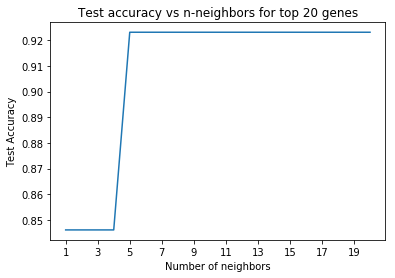

In [135]:
plt.plot(range(1, 21), scores[20])
plt.title("Test accuracy vs n-neighbors for top 20 genes")
plt.xlabel("Number of neighbors")
plt.ylabel("Test Accuracy")
plt.xticks(range(1, 21, 2))

([<matplotlib.axis.XTick at 0x7fb696f34710>,
 <a list of 10 Text xticklabel objects>)

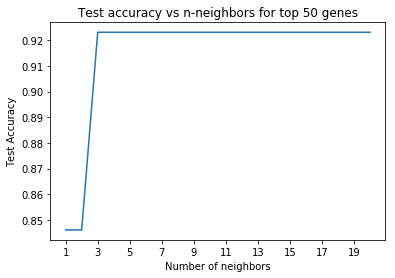

In [136]:
plt.plot(range(1, 21), scores[50])
plt.title("Test accuracy vs n-neighbors for top 50 genes")
plt.xlabel("Number of neighbors")
plt.ylabel("Test Accuracy")
plt.xticks(range(1, 21, 2))